In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import warnings 
from time import time
from pathlib import Path
from itertools import product
from collections import defaultdict
from typing import Optional, Any, Callable, Iterator, Iterable

from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, RepeatedKFold

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from source.models.QCPR import QCPR
from source.models.QCPRf import QCPRf
from source.features import FFeature
from source.data_functions import load_prepare_data

warnings.filterwarnings("ignore")

REG_TASK = 'regression'
CLS_TASK = 'classification'
DATA_DIR = Path('./data')
PARAMS = {
    'figure.figsize': (10, 5),
    'figure.constrained_layout.use': True,
    'figure.facecolor': 'white',
    'font.size': 10,
    'axes.labelsize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titlesize': 16,
    'figure.max_open_warning': 50,
}
sns.set_theme()

### Helping Functions:

In [2]:
def create_dir_if_not_exists(directory: str) -> os.PathLike:
    path = Path(directory)
    if not path.exists():
        path.mkdir(parents=True, exist_ok=True)
    return path

def query_df(df_res, query: dict) -> pd.DataFrame:
    mask = 1
    for col, val in query.items():
       mask &= (df_res[col] == val)
    return df_res[mask]

def extend_results_dict(res: dict, **kwargs) -> None:
    for key, value in kwargs.items():
        res[key].extend(value.copy())

def update_results_dict(res: dict, **kwargs) -> None:
    for key, value in kwargs.items():
        res[key].append(value)

def dirprod_dict(dt: dict[str, list[Any]]) -> Iterator[dict[str, Any]]:
    keys = dt.keys()
    for vals in product(*dt.values()):
        yield dict(zip(keys, vals))

def get_mse_for_model(model, x_train, x_test, y_train, y_test):
    y_train_mean, y_train_std = y_train.mean(), y_train.std()
    y_train = (y_train - y_train_mean) / y_train_std
    y_test = (y_test - y_train_mean) / y_train_std
    model.fit(x_train, y_train) 
    return mean_squared_error(y_test, model.predict(x_test))

def model_factory(model_cls, params, task: str = REG_TASK):
    tasks = [REG_TASK, CLS_TASK]
    if task not in tasks:
        raise ValueError(f'Bad task: {task}. Need one of these: {tasks}')
    return Pipeline([('scaler', MinMaxScaler()), (task, model_cls(**params))])

def prepare_for_dump(dt):
    for k in dt.keys():
        if isinstance(dt[k][0], np.ndarray):
            dt[k] = [list(v) for v in dt[k]]
    return dt

def replace_outliers_with_median(arr: np.ndarray) -> np.ndarray:
    outlier_const = 1.5
    uq, lq = np.percentile(arr, 80), np.percentile(arr, 20)
    iqr = (uq - lq) * outlier_const
    q_set = (uq - iqr, lq + iqr) 
    return np.where((arr >= q_set[0]) & (arr <= q_set[1]), arr, np.median(arr))

def plot_training_stats(
    df: pd.DataFrame, 
    p_scale_list: list, 
    plot_settings: list[dict],
    suptitle: str = '',
    figsize: tuple[int] = (15, 7),
    save_path: Optional[str] = None,
    replace_outliers: bool = False,
    show_plot: bool = True,
    lambda_show: bool = True,
):
    n_plots, n_cols = len(plot_settings) + 1, 3
    n_rows = int(np.ceil(n_plots / n_cols))
    max_n_plots =  n_rows * n_cols
    with mpl.rc_context(PARAMS):
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        for plot_i, ps in enumerate(plot_settings):
            i1, i2 = divmod(plot_i, n_cols)
            x, y = df[ps['x']], df[ps['y']]
            if replace_outliers: 
                y = replace_outliers_with_median(y)
            axs[i1, i2].plot(x, y, '*-', color=ps['color'])
            axs[i1, i2].set_xlabel(ps['xlabel'])
            axs[i1, i2].set_ylabel(ps['ylabel'])
            axs[i1, i2].get_yaxis().get_major_formatter().set_useOffset(False)
        
        plot_i += 1
        # Lambda dynamics:
        if lambda_show:
            i1, i2 = divmod(plot_i, n_cols)
            f_dynamics = np.array(df['lambdas'].to_list()).T
            for i in range(len(f_dynamics)):
                axs[i1, i2].plot(f_dynamics[i], label=f'FFp={p_scale_list[i]}')
            axs[i1, i2].set_xlabel('Step')
            axs[i1, i2].set_ylabel('Lambda value')
            axs[i1, i2].legend()
            plot_i += 1
        # Turn off empty plots:
        for i in range(plot_i, max_n_plots):
            i1, i2 = divmod(i, n_cols)
            axs[i1, i2].axis("off")
        plt.grid(True)
        fig.suptitle(suptitle, fontsize=16)
        if save_path: 
            plt.savefig(save_path)
        if show_plot:
            plt.show()
        else:
            plt.close()

### Different Optimization Problems (Regularization for $\lambda$):

In [3]:
def prepare_train_funct_fl(model_params):
    def train_model(x, y):
        model = model_factory(QCPRf, model_params, REG_TASK) 
        model.fit(x, y)  
        return model, 'FL_Model'
    return train_model

def load_transform_data(data_path, test_size, split_seed, transform_x: bool = True, transform_y: bool = True):
    x, x_test, y, y_test = load_prepare_data(data_path, test_size, split_seed)
    if transform_x: 
        mms = MinMaxScaler()
        mms.fit(x)
        x, x_test = mms.transform(x), mms.transform(x_test)  
    if transform_y:
        y_mean, y_std = y.mean(), y.std()
        y, y_test = (y - y_mean) / y_std, (y_test - y_mean) / y_std
    return x, x_test, y, y_test

def train_model_time(train_model: Callable, x: np.ndarray, y: np.ndarray) -> dict:
    start_t = time()
    model, model_name = train_model(x, y)
    end_time = time() - start_t
    return dict(model=model, model_name=model_name, train_time=end_time)

def get_stats_several_trials(
    data_path: str,
    train_model: Callable,
    metric_f: Callable,
    n_trials: int = 10,
    test_size: float = 0.2,
    tqdm_disable: bool = False,
    transform_x: bool = False,
    transform_y: bool = True,
):
    res = defaultdict(list)
    for trial in tqdm(range(1, n_trials + 1), disable=tqdm_disable): # Do several trials to get mean and std of metrics
        x, x_test, y, y_test = load_transform_data(
            data_path, test_size, trial, transform_x, transform_y)
        model_dt = train_model_time(train_model, x, y)
        # Compute stats:
        final_score = metric_f(y_test, model_dt['model'].predict(x_test))
        update_results_dict(
            res, trial=trial, model=model_dt['model_name'], 
            metric=final_score, train_time=model_dt['train_time'],
        )
    return res

def data2model_params(data_name: str, reg_type: str, l_pos: bool, p_scale_list: list) -> dict:
    fixed_p = dict(n_epoch=10, alpha=1e-2, random_state=13)
    if data_name == 'airfoil': # X=(1201, 5)-> 5*4*51=1020(U)
        data_p = dict(rank=51, m_order=4) 
    elif data_name == 'energy': # X=(614 8)-> 8*4*15=480(U)
        data_p = dict(rank=15, m_order=4)
    elif data_name == 'yacht': # X=(246, 6)-> 6*2*6=72(U)
        data_p = dict(rank=6, m_order=2)
    elif data_name == 'wine': # X=(5197, 11)-> 11*16*25=4400(U)
        data_p = dict(rank=25, m_order=16) 
    elif data_name == 'concrete': # X=(824, 8)-> 8*8*10=640(U)
        data_p = dict(rank=10, m_order=8)
    model_p = dict(
        fmaps_list=list(map(FFeature, p_scale_list)), 
        positive_lambda=l_pos,
        beta=1e-1, 
        lambda_reg_type=reg_type, 
        n_steps_l1=500, 
        update_order_t='lw'
    )
    return fixed_p | data_p | model_p

N_TRIALS = 10
TEST_SIZE = 0.2
METRIC_F = mean_squared_error
P_SCALE_LIST = [10, 2, 128, 25, 64, 600, 2000, 1024]
DATA_NAMES = ['airfoil', 'energy', 'yacht', 'concrete', 'wine']

DIR_NAME = 'Regularization_Study'
RES_DIR = create_dir_if_not_exists(f'./artifacts/{DIR_NAME}')
RES_PATH = RES_DIR / 'results.json'

Instructions:

In [ ]:
TRAIN = True

if TRAIN:  
    final_res = defaultdict(dict)
    for dn in DATA_NAMES:  
        DATA_PATH = DATA_DIR / f'{dn}.csv'
        for reg_type in ['l1', 'l2', 'fixed_norm']:
            for l_pos in [True, False]:
                train_model_f = prepare_train_funct_fl(
                    data2model_params(dn, reg_type, l_pos, P_SCALE_LIST)
                )
                res = get_stats_several_trials(
                    DATA_PATH, train_model_f, METRIC_F, N_TRIALS, TEST_SIZE
                )
                mode = reg_type + ('_pos' if l_pos else '_any')
                final_res[dn][mode] = res
    with open(RES_PATH, 'w') as outfile:
        json.dump(final_res, outfile)
else:
    with open(RES_PATH, 'r') as f:
        final_res = json.load(f)

ffr = defaultdict(list)
for dn in DATA_NAMES:  
    for reg_type in ['l1', 'l2', 'fixed_norm']:
        for l_pos in [True, False]:
            mode = reg_type + ('_pos' if l_pos else '_any')
            Vmc_model = np.round(np.std(final_res[dn][mode]['metric']), 3)
            m = np.mean(final_res[dn][mode]['metric'])
            t = np.mean(final_res[dn][mode]['train_time'])
            ffr['data'].append(dn)
            ffr['Regularization'].append(mode.replace('_any', ''))
            ffr['MSE'].append(m)
            ffr['Time'].append(t)
df_res = pd.DataFrame(ffr)
df_res = pd.pivot(df_res, columns=['data'], index=['Regularization'])
display(df_res.reset_index())

In [ ]:
df_res['Time'] = df_res['Time'].round(1).astype(str)
df_res['MSE'] = df_res['MSE'].round(3).astype(str)

caption = (
    f'Influence of regularization on the FL model quality for various datasets. (Average values from {N_TRIALS} restarts). '
    + '"regularization" column represents different regularization regimes: "fn" - fixed norm, "l1", "l2"; suffix "_pos" presents positive values constraint on the solution.'
)
latex_str = (
    df_res
    .to_latex(
        float_format="%.3f", 
        multicolumn_format='c||',
        column_format='||c|c|c|c|c|c||c|c|c|c|c||',
        multicolumn=True, 
        caption=caption,
        label="table:comparison_configs",
        multirow=False,
        index=True)
    .replace('_', '-')
    .replace('fixed-norm', 'fn')
)
print(latex_str)

### FL Model Compared to Cross-Validation:

In [15]:
def train_model_time(train_model: Callable, x: np.ndarray, y: np.ndarray) -> dict:
    start_t = time()
    model, model_name = train_model(x, y)
    end_time = time() - start_t
    return dict(model=model, model_name=model_name, train_time=end_time)

def load_transform_data(data_path, test_size, split_seed, transform_x: bool = True, transform_y: bool = True):
    x, x_test, y, y_test = load_prepare_data(data_path, test_size, split_seed)
    if transform_x: 
        mms = MinMaxScaler()
        mms.fit(x)
        x, x_test = mms.transform(x), mms.transform(x_test)  
    if transform_y:
        y_mean, y_std = y.mean(), y.std()
        y, y_test = (y - y_mean) / y_std, (y_test - y_mean) / y_std
    return x, x_test, y, y_test

def plot_mean_conf(
    df: pd.DataFrame, 
    x_col: str, 
    y_col: str, 
    std_col: str,
    sep_col: str,
    x_label: str = '',
    y_label: str = '',
    title: str = '',
    save_path: str = '',
    show_plot: bool = True,
    y_scale: str = 'linear',
    x_ticks: Optional[Iterable] = None,
):
    with mpl.rc_context(PARAMS):
        for value in df[sep_col].unique():
            subset = df[df[sep_col] == value]
            upper = subset[y_col] + subset[std_col]
            lower = subset[y_col] - subset[std_col]
            if y_scale == 'log':
                lower[lower < 0] = np.median(lower[lower >= 0])
            plt.fill_between(subset[x_col], lower, upper, alpha=0.2)
        sns.lineplot(x=x_col, y=y_col, data=df, hue=sep_col, markers=True, style=sep_col, dashes=False)
        plt.xticks(x_ticks)
        plt.yscale(y_scale)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        if save_path: 
            plt.savefig(save_path, dpi=500)
        if show_plot:
            plt.show()
        else:
            plt.close()

def get_stats_several_trials(
    data_path: str,
    train_model: Callable,
    metric_f: Callable,
    n_trials: int = 10,
    test_size: float = 0.2,
    tqdm_disable: bool = False,
    transform_x: bool = False,
    transform_y: bool = True,
):
    res = defaultdict(list)
    for trial in tqdm(range(1, n_trials + 1), disable=tqdm_disable): # Do several trials to get mean and std of metrics
        x, x_test, y, y_test = load_transform_data(
            data_path, test_size, trial, transform_x, transform_y)
        model_dt = train_model_time(train_model, x, y)
        # Compute stats:
        final_score = metric_f(y_test, model_dt['model'].predict(x_test))
        update_results_dict(
            res, trial=trial, model=model_dt['model_name'], 
            metric=final_score, train_time=model_dt['train_time'],
        )
    return res
            
def data2model_params(data_name: str, model_name: str, p_scale_list: list) -> dict:
    fixed_p = dict(n_epoch=10, alpha=1e-2, random_state=13)
    if data_name == 'airfoil': # X=(1201, 5)-> 5*4*51=1020(U)
        data_p = dict(rank=51, m_order=4) 
    elif data_name == 'energy': # X=(614 8)-> 8*4*15=480(U)
        data_p = dict(rank=15, m_order=4)
    elif data_name == 'yacht': # X=(246, 6)-> 6*2*6=72(U)
        data_p = dict(rank=6, m_order=2)
    elif data_name == 'wine': # X=(5197, 11)-> 11*16*25=4400(U)
        data_p = dict(rank=25, m_order=16) 
    elif data_name == 'concrete': # X=(824, 8)-> 8*8*10=640(U)
        data_p = dict(rank=10, m_order=8)
    elif data_name == 'airline':
        data_p = dict(rank=20, m_order=64) 

    if model_name == 'FL_Model':
        model_p = dict(
            fmaps_list=list(map(FFeature, p_scale_list)),
            beta=1e-1, 
            lambda_reg_type='l1', 
            n_steps_l1=500, 
            update_order_t='lw'
        )
        return fixed_p | data_p | model_p
    elif model_name == 'CV_Model':
        model_params = dict(
            features_list=list(map(FFeature, p_scale_list)),
            n_jobs=1, 
            n_splits=3, 
            n_repeats=2, 
            kfold_rs=1,
            fixed_params=fixed_p | data_p,
        )
        return model_params
    
def prepare_train_funct_fl(model_params):
    def train_model(x, y):
        model = model_factory(QCPRf, model_params, REG_TASK) 
        model.fit(x, y)  
        return model, 'FL_Model'
    return train_model

def prepare_train_funct_cv(model_params):
    def train_model(x, y):
        all_scores = []
        for value in model_params['features_list']:
            params = dict(feature_map=value) | model_params['fixed_params']
            model = model_factory(QCPR, params, REG_TASK)
            cv = RepeatedKFold(
                n_splits=model_params['n_splits'],
                n_repeats=model_params['n_repeats'], 
                random_state=model_params['kfold_rs']
            )
            scores = cross_val_score(
                model, x, y, scoring='neg_mean_squared_error', cv=cv, 
                n_jobs=model_params['n_jobs'])
            all_scores.append(np.mean(scores))

        best_feature = model_params['features_list'][np.argmax(all_scores)]
        params = dict(feature_map=best_feature) | model_params['fixed_params']
        model = model_factory(QCPR, params, REG_TASK)
        model.fit(x, y)  
        return model, 'CV_Model'
    return train_model

def data2train_f(data_name: str, model_name: str, p_scale_list: list) -> Callable:
    if model_name == 'FL_Model':
        return prepare_train_funct_fl(data2model_params(data_name, model_name, p_scale_list))
    elif model_name == 'CV_Model':
        return prepare_train_funct_cv(data2model_params(data_name, model_name, p_scale_list))

N_TRIALS = 10
TEST_SIZE = 0.2
METRIC_F = mean_squared_error
P_SCALE_LIST = [10, 2, 128, 25, 64, 600, 2000, 1024]

Instructions:

In [ ]:
TRAIN = False
DATA_NAME = 'yacht' # yacht / airfoil / energy / concrete / wine

DATA_PATH = DATA_DIR / f'{DATA_NAME}.csv'
DIR_NAME = 'FLvsCV'
RES_DIR = create_dir_if_not_exists(f'./artifacts/{DIR_NAME}/{DATA_NAME}')
RES_PATH = RES_DIR / 'results.json'

if TRAIN:
    res = defaultdict(list)
    for model_name in ['FL_Model', 'CV_Model']:
        for nps in range(1, len(P_SCALE_LIST) + 1):
            p_scale_list = P_SCALE_LIST[:nps]
            train_model_f = data2train_f(DATA_NAME, model_name, p_scale_list)
            _res = get_stats_several_trials(
                DATA_PATH, train_model_f, METRIC_F, N_TRIALS, TEST_SIZE
            )
            extend_results_dict(res, n_features=[nps,]*N_TRIALS, **_res)
    res = prepare_for_dump(res)
    with open(RES_PATH, 'w') as outfile:
        json.dump(res, outfile)
    df_res = pd.DataFrame(res)
else:
    with open(RES_PATH, 'r') as f:
        res = json.load(f)
    df_res = pd.DataFrame(res)

#### Dynamical Behavior of Models:

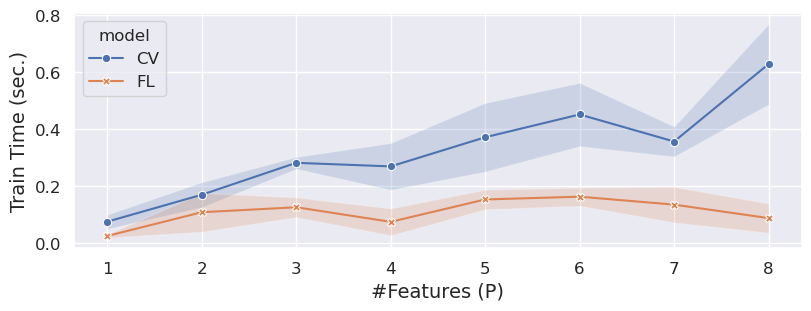

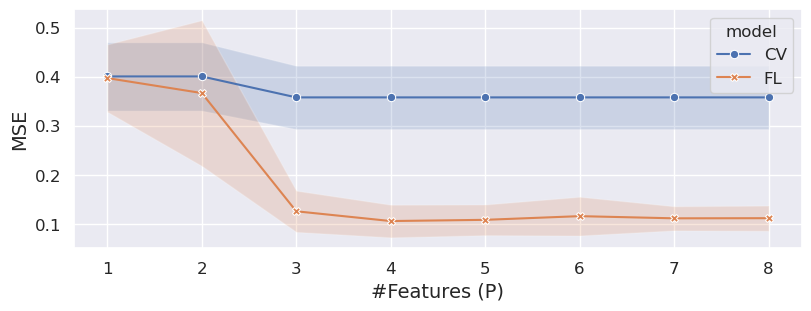

In [19]:
show_plot = True
y_scale_mse = 'linear'
_title = f'({DATA_NAME.capitalize()} dataset)'
params_list = [
    dict(
        y_col='train_time', 
        y_label='Train Time (sec.)', 
        title=f'Training Time vs #Features {_title}',
        y_scale='linear',
    ),
    dict(
        y_col='metric', 
        y_label=f'{y_scale_mse}(MSE)' if y_scale_mse == 'log' else 'MSE', 
        title=f'Prediction quality vs #Features {_title}', 
        y_scale=y_scale_mse,
    ),
]

for i, params in enumerate(params_list):
    x_col, y_col, y_label = 'n_features', params['y_col'], params['y_label']
    title, y_scale = params['title'], params['y_scale']
    grouped_df = (
        df_res.groupby([x_col, 'model'])[y_col].agg(['mean', 'std'])
        .reset_index().rename(columns={'mean': y_col}))
    
    grouped_df['model'] = grouped_df['model'].str.removesuffix('_Model')
    save_path = RES_DIR / f'{DIR_NAME}_{DATA_NAME}_{y_col}.png'
    
    plot_mean_conf(
        grouped_df, x_col, y_col, 'std', 'model', '#Features (P)', y_label, 
        '', save_path, show_plot, y_scale, grouped_df[x_col].unique(),
    )

#### Table Comparison of FL Model and CV for Small/Large-Scale Data: 

In [20]:
def get_res_df(data_name: str) -> pd.DataFrame:
    with open(f'./artifacts/{DIR_NAME}/{data_name}/results.json', 'r') as f:
        res = json.load(f)
    return pd.DataFrame(res)

def cv_pscale_in_fl_pscale(x):
    return (
        x[x['model'] == 'CV5Folds']['best_p_scales'].item()[0] 
        in x[x['model'] == 'FLModel']['best_p_scales'].item()
    )

RES_DIR = create_dir_if_not_exists(f'./artifacts/{DIR_NAME}/{DATA_NAME}')
RES_NAME = 'results'
RES_PATH = RES_DIR / f'{RES_NAME}.json'

def get_res_table(data_names, n_features):
    res_dict = defaultdict(list)
    for data_name in data_names:
        # Model stats:
        dd = query_df(get_res_df(data_name), dict(n_features=n_features))
        ms = defaultdict(dict)
        for model in ['FL_Model', 'CV_Model']:
            dd_model = query_df(dd, dict(model=model))
            Vmc_model = np.round(np.std(dd_model['metric']), 3)
            ms[model]['metric'] = f"{np.round(np.mean(dd_model['metric']), 4)} $\\pm$ {Vmc_model}"
            _time = np.mean(dd_model['train_time'])
            if _time < 1:
                _time = np.round(_time, 3)
            elif _time < 10:
                _time = np.round(_time, 1)
            else:
                _time = np.int64(_time)
            ms[model]['time'] = f"{_time}"
            if model == 'FL_Model':
                model_params = data2model_params(data_name, model, [])
                m_order, rank = model_params['m_order'], model_params['rank']
        # Data stats:
        _x1, _x2, _, _ = load_prepare_data(DATA_DIR / f'{data_name}.csv', TEST_SIZE, split_seed=None)
        n_samples, d_dim = _x1.shape[0] + _x2.shape[0], _x1.shape[-1]
        # Combine all the stats:
        update_results_dict(res_dict, Data=data_name, N=n_samples, D=d_dim, M=m_order, R=rank,
            MSE_FL=ms['FL_Model']['metric'], MSE_CV=ms['CV_Model']['metric'],
            TT_FL=ms['FL_Model']['time'], TT_CV=ms['CV_Model']['time'],
        )
    return res_dict

data_names = ['airfoil', 'energy', 'yacht', 'concrete', 'wine']
n_features = len(P_SCALE_LIST)
df_temp = pd.DataFrame(get_res_table(data_names, n_features))
display(df_temp)

,Data,N,D,M,R,MSE_FL,MSE_CV,TT_FL,TT_CV
0,airfoil,1502,5,4,51,0.1836 $\pm$ 0.023,0.2227 $\pm$ 0.021,3.0,23
1,energy,768,8,4,15,0.0032 $\pm$ 0.0,0.0026 $\pm$ 0.0,0.91,5.5
2,yacht,308,6,2,6,0.1117 $\pm$ 0.024,0.3578 $\pm$ 0.061,0.149,0.615
3,concrete,1030,8,8,10,0.1388 $\pm$ 0.032,0.1181 $\pm$ 0.016,1.2,8.8
4,wine,6497,11,16,25,0.6918 $\pm$ 0.067,0.652 $\pm$ 0.043,33,152


In [21]:
caption = (
    f'Statistics of FL and CV models on different datasets for the number of features={n_features} (6 for airline) calculated from {N_TRIALS} restarts (5 for airline). '
    + 'MSE_FL - the average MSE value for FL model within 1 std; MSE_CV - the average MSE value for CV model within 1 std; '
    + 'TT_FL - the average time to train FL model; TT_CV - the average time to train CV model; '
    + 'N - the number of data samples; D - the dimensionality of a dataset; M - the number of basis functions per dimension; R - CPD rank;'
)

print(
    (
        df_temp
        .to_latex(
            float_format="%.3f", 
            column_format='||l|c|c|c|c|c|c|c|c|c|c||',
            caption=caption,
            label="table:cv_fl_comparison",
            multirow=False,
            index=False,
        ).replace('_', '-')
    )
)

\begin{table}
\caption{Statistics of FL and CV models on different datasets for the number of features=8 (6 for airline) calculated from 10 restarts (5 for airline). MSE-FL - the average MSE value for FL model within 1 std; MSE-CV - the average MSE value for CV model within 1 std; TT-FL - the average time to train FL model; TT-CV - the average time to train CV model; N - the number of data samples; D - the dimensionality of a dataset; M - the number of basis functions per dimension; R - CPD rank;}
\label{table:cv-fl-comparison}
\begin{tabular}{||l|c|c|c|c|c|c|c|c|c|c||}
\toprule
Data & N & D & M & R & MSE-FL & MSE-CV & TT-FL & TT-CV \\
\midrule
airfoil & 1502 & 5 & 4 & 51 & 0.1836 $\pm$ 0.023 & 0.2227 $\pm$ 0.021 & 3.0 & 23 \\
energy & 768 & 8 & 4 & 15 & 0.0032 $\pm$ 0.0 & 0.0026 $\pm$ 0.0 & 0.91 & 5.5 \\
yacht & 308 & 6 & 2 & 6 & 0.1117 $\pm$ 0.024 & 0.3578 $\pm$ 0.061 & 0.149 & 0.615 \\
concrete & 1030 & 8 & 8 & 10 & 0.1388 $\pm$ 0.032 & 0.1181 $\pm$ 0.016 & 1.2 & 8.8 \\
wine & 6497 